In [2]:
import pandas as pd
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('../clean-datasets/primary.csv')

In [4]:
import ast

# Function to extract 'sentimentScore' from the 'sentiment' string
def extract_sentiment_score(sentiment_str):
    try:
        sentiment_dict = ast.literal_eval(sentiment_str)
        # Extract the 'sentimentScore'
        return sentiment_dict.get('sentimentScore', None)
    except (ValueError, SyntaxError):
        return None

# Apply the function to the 'sentiment' column and create a new column 'sentimentScore'
df['sentimentScore'] = df['sentiment'].apply(extract_sentiment_score)

In [5]:
numerical_cols = [
    'year_founded',
    'investor_count',
    'mosaic_change',
    'funding_total_millions',
    'last_funding_millions',
    'funding_count',
    'sentimentScore'
]

In [6]:
print(df[numerical_cols].isnull().sum())


year_founded              0
investor_count            0
mosaic_change             0
funding_total_millions    0
last_funding_millions     0
funding_count             0
sentimentScore            0
dtype: int64


In [7]:
df.drop([9,3313], inplace = True)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])


In [9]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [10]:
df['cluster'] = kmeans.labels_


In [11]:
print(df['cluster'].value_counts())


2    3414
1    1940
0     153
Name: cluster, dtype: int64


In [12]:
cluster_profiles = df.groupby('cluster')[numerical_cols].mean()
print(cluster_profiles)


         year_founded  investor_count  mosaic_change  funding_total_millions  \
cluster                                                                        
0         2015.209150       19.686275     -17.058824             1160.205882   
1         2014.214433       15.649485     -37.505670              130.425923   
2         2018.084359        8.507616     -13.135325               43.507496   

         last_funding_millions  funding_count  sentimentScore  
cluster                                                        
0                   342.752026       8.607843       85.032680  
1                    33.632320       8.446392       92.418557  
2                    21.976216       3.888694       92.707674  


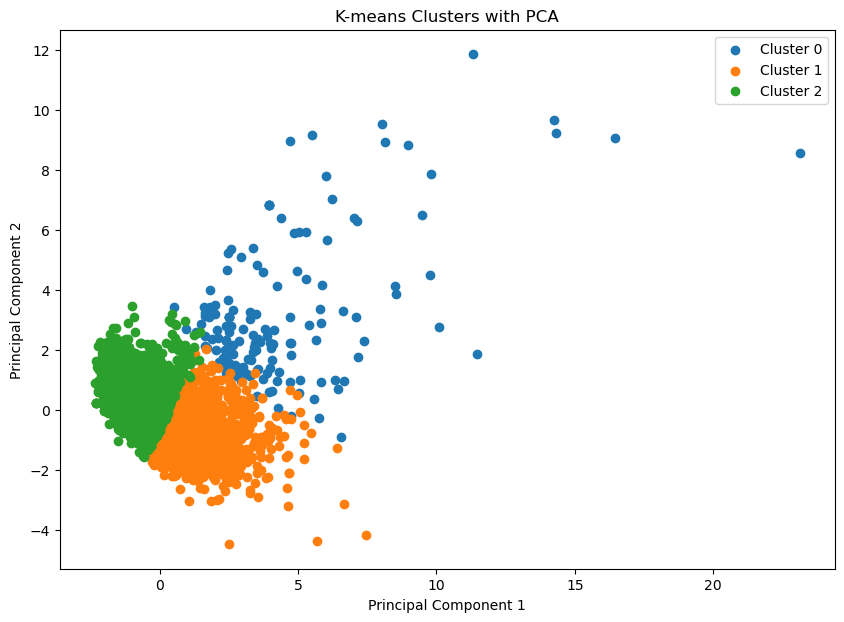

In [13]:
from sklearn.decomposition import PCA

# Reduce to 2 principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for the principal components
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(k):
    cluster_data = pc_df[pc_df['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.title('K-means Clusters with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

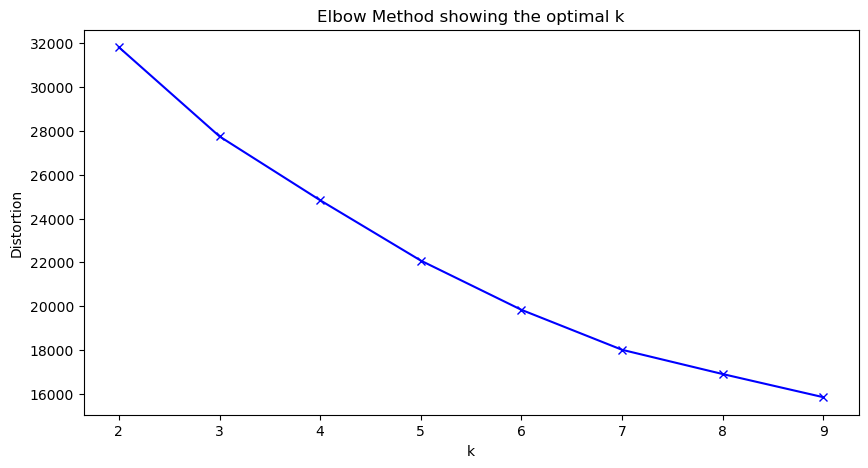

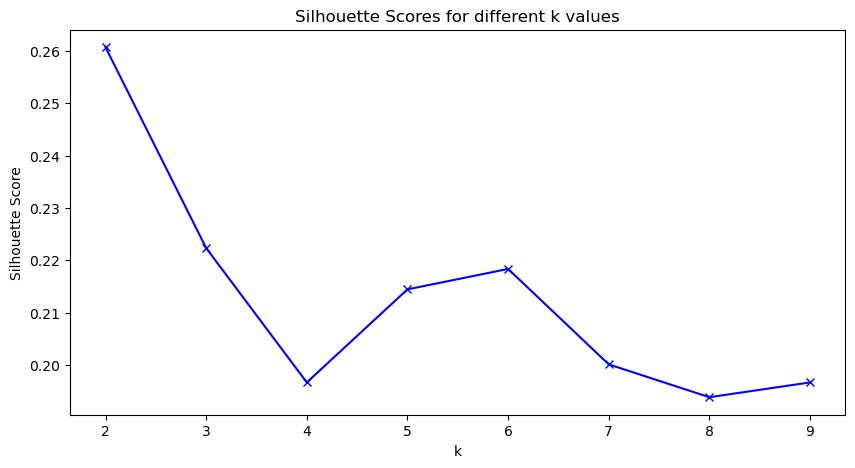

In [14]:
from sklearn.metrics import silhouette_score

# Calculate distortions for a range of k values
distortions = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(X_scaled)
    distortions.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_model.labels_))

# Plot the elbow chart
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing the optimal k')
plt.show()

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different k values')
plt.show()


In [15]:
# Install NLTK if not already installed
!pip install nltk

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Download required NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
# Define English stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords if necessary
custom_stopwords = set(['company', 'business', 'service', 'services', 'provide', 'provides', 'offering', 'offers'])
stop_words.update(custom_stopwords)

# Define punctuation to remove
punctuation = set(string.punctuation)


In [17]:
from collections import Counter

for cluster_num in range(k):
    print(f"\n--- Cluster {cluster_num} ---")
    
    # Extract descriptions for the current cluster
    cluster_descriptions = df[df['cluster'] == cluster_num]['description']
    
    # Combine all descriptions into one text
    text = ' '.join(cluster_descriptions)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove punctuation and non-alphabetic tokens
    words = [word for word in words if word.isalpha()]
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Count word frequencies
    word_counts = Counter(words)
    
    # Get the most common words
    most_common_words = word_counts.most_common(20)
    
    # Print the most common words for the cluster
    print("Most common words in descriptions:")
    for word, count in most_common_words:
        print(f"{word}: {count}")



--- Cluster 0 ---
Most common words in descriptions:
based: 154
founded: 153
primarily: 77
serves: 70
platform: 68
industry: 61
solutions: 58
technology: 57
california: 56
sectors: 49
including: 42
focuses: 38
providing: 38
management: 38
within: 37
healthcare: 35
financial: 35
specializes: 34
designed: 34
data: 34

--- Cluster 1 ---
Most common words in descriptions:
based: 1964
founded: 1936
primarily: 972
platform: 971
serves: 878
solutions: 845
technology: 770
industry: 736
sector: 678
within: 603
management: 579
data: 577
sectors: 564
specializes: 547
california: 496
healthcare: 486
providing: 469
including: 453
new: 436
financial: 425

--- Cluster 2 ---
Most common words in descriptions:
based: 3474
founded: 3405
primarily: 1850
platform: 1754
serves: 1547
industry: 1521
solutions: 1202
sector: 1193
technology: 1165
data: 1119
within: 1107
management: 1101
specializes: 934
providing: 878
sectors: 866
california: 806
healthcare: 758
focuses: 758
designed: 724
including: 695

--- 

In [18]:
from collections import Counter

for cluster_num in range(k):
    print(f"\n--- Cluster {cluster_num} ---")
    
    # Extract concepts for the current cluster
    cluster_concepts = df[df['cluster'] == cluster_num]['concepts']
    
    # Combine all concepts into one text
    text = ' '.join(cluster_concepts).lower()
    
    # Tokenize the text into words (assuming concepts are separated by commas or spaces)
    # If concepts are comma-separated
    words = [word.strip() for word in text.split(',')]
    
    # Remove empty strings and punctuation
    words = [word for word in words if word and word.isalpha()]
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Count word frequencies
    word_counts = Counter(words)
    
    # Get the most common words
    most_common_words = word_counts.most_common(20)
    
    # Print the most common words for the cluster
    print("Most common concepts in cluster:")
    for word, count in most_common_words:
        print(f"{word}: {count}")



--- Cluster 0 ---
Most common concepts in cluster:
healthcare: 4
quality: 2
compliance: 2
selling: 2
investments: 2
security: 2
detection: 2
certifications: 2
retail: 2
electronics: 2
speed: 1
swg: 1
executives: 1
bars: 1
breweries: 1
data: 1
insead: 1
wharton: 1
transportation: 1
collaboration: 1

--- Cluster 1 ---
Most common concepts in cluster:
healthcare: 13
compliance: 12
safety: 11
analytics: 10
security: 8
government: 8
finance: 7
quality: 7
efficiency: 7
flexibility: 6
marketing: 6
retail: 5
technology: 5
reliability: 5
sustainability: 5
speed: 5
transparency: 4
hospitality: 4
manufacturing: 4
managing: 4

--- Cluster 2 ---
Most common concepts in cluster:
security: 27
healthcare: 19
compliance: 15
efficiency: 15
startups: 14
reliability: 11
quality: 9
executives: 9
scalability: 8
marketing: 8
safety: 8
reliable: 7
benefits: 7
reporting: 7
speed: 7
insurance: 7
collaboration: 7
analytics: 7
selling: 6
finance: 6

--- Cluster 3 ---
Most common concepts in cluster:

--- Cluster

In [19]:
df.to_csv('primary_with_cluster_labels.csv', index = False)